In [1]:
import numpy as np
import tensorflow as tf 
import sys 
import pathlib
import json 
import os
import matplotlib.pyplot as plt
os.chdir('/project/lhansen/Capital_NN_variant/TwoAgentsDataFeedback/')
from IntraTemporalSolver import *
import model

In [63]:
 
 
tensorboard = "True"


## Load parameters /project/lhansen/Capital_NN_variant/TwoAgentsAI/GPUAsset_changing_Iota_LR_piecewiseconstant_40e-6,40e-6,40e-6,40e-6_num_iterations100000_output_layer_activations_softplus,softplus,softplus,softplus
export_folder                    = "/project/lhansen/Capital_NN_variant/TwoAgentsDataFeedback/output/AI_Economy_prices_piecewiseconstant_40e-5,40e-5,40e-5,40e-5_num_iterations100000_hidden_layer_activations_swish,tanh,tanh,tanh_output_layer_activations_softplus,sigmoid,sigmoid,sigmoid"
export_folder                    = "/project/lhansen/Capital_NN_variant/TwoAgentsDataFeedback/output/WithoutScalers_piecewiseconstant_40e-5,40e-5,40e-5,40e-5_num_iterations200000_hidden_layer_activations_swish,tanh,tanh,tanh_output_layer_activations_softplus,sigmoid,sigmoid,sigmoid"
export_folder                    = "/project/lhansen/Capital_NN_variant/TwoAgentsDataFeedback/output/AI_Without_Scalers_piecewiseconstant_40e-5,40e-5,40e-5,40e-5_num_iterations2000000_hidden_layer_activations_swish,tanh,tanh,tanh_output_layer_activations_softplus,sigmoid,sigmoid,sigmoid"
# export_folder                    = "/project/lhansen/Capital_NN_variant/TwoAgentsDataFeedback/output/AI_Economy_prices_piecewiseconstant_40e-5,40e-5,40e-5,40e-5_num_iterations100000_hidden_layer_activations_swish,tanh,tanh,tanh_output_layer_activations_softplus,sigmoid,sigmoid,sigmoid"

batch_size                       = int(128)
num_iterations                   = int(2000000)

logging_frequency                = int(100)
learning_rates                   = [float(x) for x in "40e-5,40e-5,40e-5,40e-5".split(",")]
hidden_layer_activations         = "swish,tanh,tanh,tanh".split(",")
output_layer_activations         = "softplus,sigmoid,sigmoid,sigmoid".split(",")
num_hidden_layers                = int(4)
num_neurons                      = int(32)
learning_rate_schedule_type      = "piecewiseconstant"
delta                            = float(0.01)
pretrained_path = None

## Take care of activation functions 
hidden_layer_activations   = [None if x == "None" else x for x in hidden_layer_activations]
output_layer_activations   = [None if x == "None" else x for x in output_layer_activations]

#############################################
## Part 1
## Solve post tech post damage model
#############################################

## This model has three state variables


v_nn_config   = {"num_hiddens" : [num_neurons for _ in range(num_hidden_layers)], "use_bias" : True, "activation" : hidden_layer_activations[0], "dim" : 1, "nn_name" : "v_nn"}
v_nn_config["final_activation"] = output_layer_activations[0]

i_g_nn_config = {"num_hiddens" : [num_neurons for _ in range(num_hidden_layers)], "use_bias" : True, "activation" : hidden_layer_activations[1], "dim" : 1, "nn_name" : "i_g_nn"}
i_g_nn_config["final_activation"] = output_layer_activations[1]

i_a_nn_config = {"num_hiddens" : [num_neurons for _ in range(num_hidden_layers)], "use_bias" : True, "activation" : hidden_layer_activations[2], "dim" : 1, "nn_name" : "i_a_nn"}
i_a_nn_config["final_activation"] = output_layer_activations[2]

i_d_nn_config = {"num_hiddens" : [num_neurons for _ in range(num_hidden_layers)], "use_bias" : True, "activation" : hidden_layer_activations[3], "dim" : 1, "nn_name" : "i_d_nn"}
i_d_nn_config["final_activation"] = output_layer_activations[3]

## Network for Labor Allocation 
## 3 outputs (L_g,L_a, N) in order
L_nn_config   = {"num_hiddens": [num_neurons for _ in range(num_hidden_layers)], "use_bias": True, "activation": "tanh", "dim": 3,  "nn_name": "Labor_nn", "final_activation": "softmax" }



## Prices network
s_g_nn_config   = {"num_hiddens" : [num_neurons for _ in range(num_hidden_layers)], "use_bias" : True, "activation" : hidden_layer_activations[0], "dim" : 1, "nn_name" : "s_g_nn"}
s_g_nn_config["final_activation"] = output_layer_activations[0]

s_a_nn_config   = {"num_hiddens" : [num_neurons for _ in range(num_hidden_layers)], "use_bias" : True, "activation" : hidden_layer_activations[0], "dim" : 1, "nn_name" : "s_a_nn"}
s_a_nn_config["final_activation"] = output_layer_activations[0]



## Create params struct 
params = {"batch_size" : batch_size,  
"v_nn_config" : v_nn_config, "s_g_nn_config" : s_g_nn_config, "s_a_nn_config" : s_a_nn_config, 
"i_g_nn_config" : i_g_nn_config,"i_a_nn_config" : i_a_nn_config,  "i_d_nn_config" : i_d_nn_config,  "L_nn_config" : L_nn_config ,
"num_iterations" : num_iterations, "logging_frequency": logging_frequency, "verbose": True, "load_parameters" : None, "norm_weight" : 0.9,
"pretrained_path" : pretrained_path, 'tensorboard' : tensorboard, "learning_rate_schedule_type" : learning_rate_schedule_type }

 


if params["learning_rate_schedule_type"] == "None":
    lr_schedulers = learning_rates
    params["optimizers"] = [tf.keras.optimizers.Adam( learning_rate = lr_scheduler) for lr_scheduler in lr_schedulers]
elif params["learning_rate_schedule_type"] == "piecewiseconstant":
    boundaries            = [int(round(x)) for x in np.linspace(0,num_iterations,5)][1:-1]
    values_list           = [[learning_rate / np.power(6,x) for x in range(len(boundaries)+1)] for learning_rate in learning_rates]
    lr_schedulers         = [ tf.keras.optimizers.schedules.PiecewiseConstantDecay(boundaries, values) for values in values_list]
    params["optimizers"] = [tf.keras.optimizers.Adam( learning_rate = lr_scheduler) for lr_scheduler in lr_schedulers]
elif params["learning_rate_schedule_type"] == "sgd+piecewiseconstant":
    boundaries            = [int(round(x)) for x in np.linspace(0,num_iterations,5)][1:-1]
    values_list           = [[learning_rate / np.power(2,x) for x in range(len(boundaries)+1)] for learning_rate in learning_rates]
    lr_schedulers         = [ tf.keras.optimizers.schedules.PiecewiseConstantDecay(boundaries, values) for values in values_list]
    params["optimizers"] = [tf.keras.optimizers.legacy.SGD( learning_rate = lr_scheduler) for lr_scheduler in lr_schedulers]
elif params["learning_rate_schedule_type"] == "sgd":
    lr_schedulers = learning_rates
    params["optimizers"] = [tf.keras.optimizers.legacy.SGD( learning_rate = lr_scheduler) for lr_scheduler in lr_schedulers]

 
params["export_folder"]  = export_folder +  "/TrainingResults"

params["phi_g"] = 7
params["phi_a"] = 6
if output_layer_activations[1] == "custom" or output_layer_activations[2] == "custom":
    params["i_g_nn_config"]["final_activation"] = lambda x: 1.0 - (1.0 + 1.0/ params["phi_g"]) / (tf.exp(2 * x) + 1.0)
    params["i_a_nn_config"]["final_activation"] = lambda x: 1.0 - (1.0 + 1.0/ params["phi_a"]) / (tf.exp(2 * x) + 1.0)


In [64]:

# Define the paths to the weights files
v_nn_checkpoint_path = params["export_folder"]+'/v_nn_checkpoint'
i_g_nn_checkpoint_path = params["export_folder"]+'/i_g_nn_checkpoint'
i_d_nn_checkpoint_path = params["export_folder"]+'/i_d_nn_checkpoint' 
i_a_nn_checkpoint_path = params["export_folder"]+'/i_a_nn_checkpoint' 
L_nn_checkpoint_path = params["export_folder"]+'/L_nn_checkpoint' 

s_g_nn_checkpoint_path = params["export_folder"]+'/s_g_nn_checkpoint' 
s_a_nn_checkpoint_path = params["export_folder"]+'/s_a_nn_checkpoint' 

In [65]:
def load_model(params, v_nn_checkpoint_path, i_g_nn_checkpoint_path,i_a_nn_checkpoint_path, i_d_nn_checkpoint_path,L_nn_checkpoint_path,s_g_nn_checkpoint_path,s_a_nn_checkpoint_path):
    test_model = model.model(params)
    
    n_inputs = 3  
    test_model.v_nn.build((params["batch_size"], n_inputs))
    test_model.i_g_nn.build((params["batch_size"], n_inputs))
    test_model.i_a_nn.build((params["batch_size"], n_inputs))
    test_model.i_d_nn.build((params["batch_size"], n_inputs)) 
    test_model.L_nn.build((params["batch_size"], n_inputs)) 
    test_model.s_g_nn.build((params["batch_size"], n_inputs))
    test_model.s_a_nn.build((params["batch_size"], n_inputs))
    
    test_model.v_nn.load_weights(v_nn_checkpoint_path)
    test_model.i_g_nn.load_weights(i_g_nn_checkpoint_path)
    test_model.i_a_nn.load_weights(i_a_nn_checkpoint_path)
    test_model.i_d_nn.load_weights(i_d_nn_checkpoint_path) 
    test_model.L_nn.load_weights(L_nn_checkpoint_path) 
    
    test_model.s_g_nn.load_weights(s_g_nn_checkpoint_path)
    test_model.s_a_nn.load_weights(s_a_nn_checkpoint_path)

    return test_model


reloaded_model =load_model(params, v_nn_checkpoint_path, i_g_nn_checkpoint_path,i_a_nn_checkpoint_path, i_d_nn_checkpoint_path,L_nn_checkpoint_path,s_g_nn_checkpoint_path,s_a_nn_checkpoint_path)

In [66]:
init_logK_g = 2
init_logK_a = 0.1
init_logD = 0.1
initial_state = tf.stack([[init_logK_g, init_logK_a,   init_logD ]])

v_g   = reloaded_model.v_nn(initial_state )[0,0]
i_g   = reloaded_model.i_g_nn(initial_state )[0,0]
i_d   = reloaded_model.i_d_nn(initial_state  )[0,0]
i_a   = reloaded_model.i_a_nn(initial_state )[0,0]
L_g   = reloaded_model.L_nn(initial_state )[0,0]
L_a   = reloaded_model.L_nn(initial_state )[0,1]
N   = reloaded_model.L_nn(initial_state )[0,2]
s_g=    reloaded_model.s_g_nn(initial_state )[0,0]
s_a=    reloaded_model.s_a_nn(initial_state )[0,0]
# Print the results.
print("v_g   =", v_g.numpy())
print("i_g   =", i_g.numpy())
print("i_d   =", i_d.numpy())
print("i_a   =", i_a.numpy())
print("L_g   =", L_g.numpy())
print("L_a   =", L_a.numpy())
print("N   =", N.numpy())
print("s_g   =", s_g.numpy()) 
print("s_a   =", s_a.numpy())

v_g   = 1.9386199
i_g   = 5.332365e-13
i_d   = 5.9500155e-05
i_a   = 2.080548e-12
L_g   = 0.022071185
L_a   = 0.07327911
N   = 0.90464973
s_g   = 0.7561975
s_a   = 0.42006227


In [67]:
init_logK_g = 2
init_logK_a = 1
init_logD = 0.1
initial_state = tf.stack([[init_logK_g, init_logK_a,   init_logD ]])

v_g   = reloaded_model.v_nn(initial_state )[0,0]
i_g   = reloaded_model.i_g_nn(initial_state )[0,0]
i_d   = reloaded_model.i_d_nn(initial_state  )[0,0]
i_a   = reloaded_model.i_a_nn(initial_state )[0,0]
L_g   = reloaded_model.L_nn(initial_state )[0,0]
L_a   = reloaded_model.L_nn(initial_state )[0,1]
N   = reloaded_model.L_nn(initial_state )[0,2]
s_g=    reloaded_model.s_g_nn(initial_state )[0,0]
s_a=    reloaded_model.s_a_nn(initial_state )[0,0]
# Print the results.
print("v_g   =", v_g.numpy())
print("i_g   =", i_g.numpy())
print("i_d   =", i_d.numpy())
print("i_a   =", i_a.numpy())
print("L_g   =", L_g.numpy())
print("L_a   =", L_a.numpy())
print("N   =", N.numpy())
print("s_g   =", s_g.numpy()) 
print("s_a   =", s_a.numpy())

v_g   = 2.2292647
i_g   = 1.2594292e-13
i_d   = 4.793386e-05
i_a   = 3.0556083e-13
L_g   = 0.019156558
L_a   = 0.06248723
N   = 0.9183562
s_g   = 0.7519753
s_a   = 0.41858464


In [110]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

def simulate_path(reloaded_model, 
                  init_logK_g, init_logK_a,  init_logD, 
                  year=10, dt=1/12):
    """
    Runs your simulation with the given initial log-states.
    
    Returns a dictionary containing all relevant paths:
      { "time_grid": ..., "K_g_path": ..., "K_a_path": ..., "Z_path": ..., etc. }
    """
    num_steps = int(year/dt)
    
    # Create the initial state and store it in a TensorArray
    initial_state = tf.stack([[init_logK_g, init_logK_a,  init_logD]])
    states = tf.TensorArray(dtype=tf.float32, size=num_steps, clear_after_read=False)
    states = states.write(0, initial_state)

    # Extract parameters from model for convenience:
    δ    = reloaded_model.params["δ"]
    ρ    = reloaded_model.params["ρ"]
    α    = reloaded_model.params["α"]
    θ    = reloaded_model.params["θ"]
    γ    = reloaded_model.params["γ"]
    ι    = reloaded_model.params["ι"]
    β    = reloaded_model.params["β"]
    ψ    = reloaded_model.params["ψ"]

    μ_a  = reloaded_model.params["μ_a"]
    κ_a  = reloaded_model.params["κ_a"]
    σ_a  = reloaded_model.params["σ_a"]
    μ_g  = reloaded_model.params["μ_g"]
    κ_g  = reloaded_model.params["κ_g"]
    σ_g  = reloaded_model.params["σ_g"]
    ζ    = reloaded_model.params["ζ"]
    ψ_0  = reloaded_model.params["ψ_0"]
    ψ_1  = reloaded_model.params["ψ_1"]
    σ_D  = reloaded_model.params["σ_D"]
    A    = reloaded_model.params["A"]
    Z    = reloaded_model.params["Z"]
    # Prepare lists to store paths
    K_g_path   = []
    K_a_path   = [] 
    D_path     = []
    
    i_d_path   = []
    i_a_path   = []
    i_g_path   = []
    
    
    Pi_g_path  = []
    Pi_a_path  = []
    L_g_path   = []
    L_a_path   = []
    w_path     = []
    p_path     = []
    s_g_path   = []
    s_a_path   = []
    v_path     = []
    flow_path  = []
    C_path     = []  # Consumption path
    y_path     = []
    v_val_path = []
    
    # Helper function: increment
    def increment(state_t):
        logK_g_t, logK_a_t, logD_t = state_t[0], state_t[1], state_t[2] 
        
        K_g_t = tf.exp(logK_g_t)
        K_a_t = tf.exp(logK_a_t)
        D_t   = tf.exp(logD_t)

        # Evaluate NNs
        v_val = reloaded_model.v_nn(state_t[tf.newaxis, :])[0,0]
        i_g   = reloaded_model.i_g_nn(state_t[tf.newaxis, :])[0,0]
        i_a   = reloaded_model.i_a_nn(state_t[tf.newaxis, :])[0,0]
        i_d   = reloaded_model.i_d_nn(state_t[tf.newaxis, :])[0,0]  
        L_g   = reloaded_model.L_nn(state_t[tf.newaxis, :])[0,0]  
        L_a   = reloaded_model.L_nn(state_t[tf.newaxis, :])[0,1]  
        s_g   = reloaded_model.s_g_nn(state_t[tf.newaxis, :])[0,0]
        s_a   = reloaded_model.s_a_nn(state_t[tf.newaxis, :])[0,0] 

        # Possibly need to set batch_size=1 for your solver
        reloaded_model.params['batch_size'] = 1


        N = 1.0 - L_a - L_g
        
        X = Z * (K_a_t**α) * (L_a**(1 - α))
        
        L_AI = (D_t**θ) * (X**(1 - θ))
        
        L_composite = (ι*(L_g**γ) + (1 - ι)*(L_AI**γ))**( 1 /γ)
        
        y = A * (K_g_t**β) * L_composite**(1 - β) 
        
        C = y - i_g*K_g_t - i_a*K_a_t - i_d*K_g_t
        
        p = (1-β) * (1-ι) * (1-θ) * y * (L_AI/ L_composite )**γ / X
        
        w=  (1-β) *  ι  *  y * (L_g/ L_composite )**γ  / L_g
        
        
         
        # Profits
        Pi_g = y - w*L_g - p*X
        Pi_a = p*X - w*L_a

        
        # Flow utility
        C_safe = tf.maximum(C, 1e-8)
        N_safe = tf.maximum(N, 1e-8)
        flow   = δ * tf.math.log(C_safe) + ψ * tf.math.log(N_safe)
        
        # Drifts
        v_k_g_term = (-μ_g + i_g - (κ_g/2)*(i_g**2) - (σ_g**2)/2)
        dlogk_g    = v_k_g_term * dt
        
        v_k_a_term = (-μ_a + i_a - (κ_a/2)*(i_a**2) - (σ_a**2)/2)
        dlogk_a    = v_k_a_term * dt
        

        v_logD_term = (-ζ + ψ_0 * ((K_g_t / D_t)*i_d * y/ D_t)**(ψ_1) - 0.5*(σ_D**2))
        dlogD     = v_logD_term * dt

        increment_state = tf.stack([dlogk_g, dlogk_a,  dlogD], axis=0)
        
        return (increment_state, i_g,i_a, i_d, 
                Pi_g, Pi_a, L_g, L_a, w, p,
                s_g, s_a, v_val, flow, C,y)

    # Record initial
    K_g_path.append(tf.exp(initial_state[0,0]).numpy())
    K_a_path.append(tf.exp(initial_state[0,1]).numpy()) 
    D_path.append(tf.exp(initial_state[0,2]).numpy())

    # Main simulation loop
    for i in range(num_steps - 1):
        current_state = states.read(i)[0]
        (inc_state, i_g_val, i_a_val, i_d_val,
         Pi_g_val, Pi_a_val, L_g_val, L_a_val, 
         w_val, p_val, s_g_val, s_a_val, 
         v_val, flow_val, C_val,y_val) = increment(current_state)

        new_state = current_state + inc_state
        states = states.write(i + 1, tf.reshape(new_state, [1,3]))

        i_d_path.append(i_d_val.numpy().item())
        i_a_path.append(i_a_val.numpy().item())
        i_g_path.append(i_g_val.numpy().item())

        Pi_g_path.append(Pi_g_val.numpy().item())
        Pi_a_path.append(Pi_a_val.numpy().item())
        L_g_path.append(L_g_val.numpy().item())
        L_a_path.append(L_a_val.numpy().item())
        w_path.append(w_val.numpy().item())
        p_path.append(p_val.numpy().item())
        s_g_path.append(s_g_val.numpy().item())
        s_a_path.append(s_a_val.numpy().item())
        v_val_path.append(v_val.numpy().item())
        flow_path.append(flow_val.numpy().item())
        C_path.append(C_val.numpy().item())
        y_path.append(y_val.numpy().item())

        K_g_path.append(tf.exp(new_state[0]).numpy())
        K_a_path.append(tf.exp(new_state[1]).numpy())
        D_path.append(tf.exp(new_state[2]).numpy())

    # Convert to numpy arrays
    K_g_path   = np.array(K_g_path)
    K_a_path   = np.array(K_a_path)
    D_path     = np.array(D_path)
    i_d_path   = np.array(i_d_path)
    i_a_path   = np.array(i_a_path)
    i_g_path   = np.array(i_g_path)
    Pi_g_path  = np.array(Pi_g_path)
    Pi_a_path  = np.array(Pi_a_path)
    L_g_path   = np.array(L_g_path)
    L_a_path   = np.array(L_a_path)
    w_path     = np.array(w_path)
    p_path     = np.array(p_path)
    s_g_path   = np.array(s_g_path)
    s_a_path   = np.array(s_a_path)
    v_val_path = np.array(v_val_path)
    flow_path  = np.array(flow_path)
    C_path     = np.array(C_path)
    y_path     = np.array(y_path)
    
    time_grid  = np.linspace(0, year, num_steps)
    time_grid_ = np.linspace(0, year, num_steps - 1)

    return {
        "time_grid": time_grid,
        "time_grid_": time_grid_,
        "K_g_path": K_g_path,
        "K_a_path": K_a_path, 
        "D_path": D_path,
        "i_d_path": i_d_path,
        "i_a_path": i_a_path,
        "i_g_path": i_g_path,
        "Pi_g_path": Pi_g_path,
        "Pi_a_path": Pi_a_path,
        "L_g_path": L_g_path,
        "L_a_path": L_a_path,
        "w_path": w_path,
        "p_path": p_path,
        "s_g_path": s_g_path,
        "s_a_path": s_a_path,
        "v_val_path": v_val_path,
        "flow_path": flow_path,
        "C_path": C_path,
        "y_path": y_path,
    }


In [126]:
# First set of initial states
paths_case1 = simulate_path(
    reloaded_model,
    init_logK_g=2,
    init_logK_a=0.5, 
    init_logD=0.3,
    year=5,
    dt=1/12
)

# Second set of initial states
paths_case2 = simulate_path(
    reloaded_model,
    init_logK_g=2,
    init_logK_a=1, 
    init_logD=0.3,
    year=5,
    dt=1/12
)


ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.ops.tensor_array_ops.TensorArray'>):
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/software/python-anaconda-2021.05-el8-x86_64/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3457, in run_code
    return outflag  File "<ipython-input-126-f2997ea6357c>", line 2, in <module>
    paths_case1 = simulate_path(  File "<ipython-input-110-f5fd144a8fcd>", line 194, in simulate_path
    return {  File "/software/python-anaconda-2021.05-el8-x86_64/lib/python3.8/site-packages/tensorflow/python/util/tf_should_use.py", line 288, in wrapped
    return _add_should_use_warning(fn(*args, **kwargs),


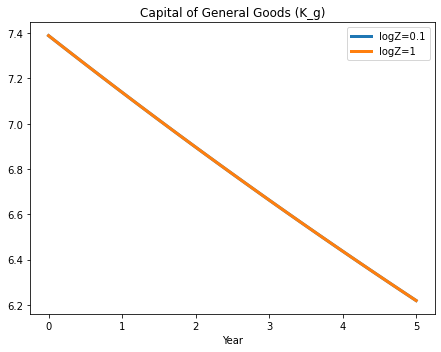

In [147]:
# Extract data
t1 = paths_case1["time_grid"]
Kg1 = paths_case1["K_g_path"]
Ka1 = paths_case1["K_a_path"]

t2 = paths_case2["time_grid"]
Kg2 = paths_case2["K_g_path"]
Ka2 = paths_case2["K_a_path"]

# Example: 2-subplots, each with 2 lines
plt.figure(figsize=(12, 5))

# Capital Good
plt.subplot(1,2,1)
plt.plot(t1, Kg1, label="logZ=0.1", lw=3)
plt.plot(t2, Kg2, label="logZ=1", lw=3)
plt.title("Capital of General Goods (K_g)")
plt.xlabel("Year")
plt.legend()

 
plt.tight_layout()
plt.show()


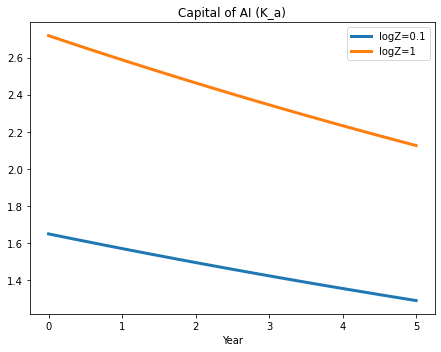

In [128]:
# Extract data
t1 = paths_case1["time_grid"]
Kg1 = paths_case1["K_g_path"]
Ka1 = paths_case1["K_a_path"]

t2 = paths_case2["time_grid"]
Kg2 = paths_case2["K_g_path"]
Ka2 = paths_case2["K_a_path"]

# Example: 2-subplots, each with 2 lines
plt.figure(figsize=(12, 5))
 

# Capital Agri
plt.subplot(1,2,2)
plt.plot(t1, Ka1, label="logZ=0.1", lw=3)
plt.plot(t2, Ka2, label="logZ=1", lw=3)
plt.title("Capital of AI (K_a)")
plt.xlabel("Year")
plt.legend()

plt.tight_layout()
plt.show()

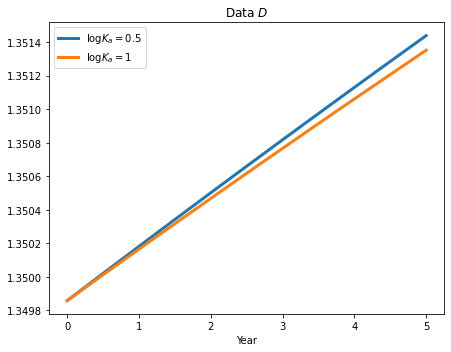

In [140]:
# Extract data
t1 = paths_case1["time_grid"]
Kg1 = paths_case1["D_path"].copy()  # make a copy so we don't modify the original array

t2 = paths_case2["time_grid"]
Kg2 = paths_case2["D_path"]

# Replace the first element of Kg1 with the first element of Kg2
Kg2[0] =Kg1[0]

# Plotting
plt.figure(figsize=(12, 5))
plt.subplot(1,2,1)
plt.plot(t1, Kg1, label="$\log{K_a}=0.5$", lw=3)
plt.plot(t2, Kg2, label="$\log{K_a}=1$", lw=3)
plt.title("Data $D$")
plt.xlabel("Year")
plt.legend()
plt.tight_layout()
plt.show()

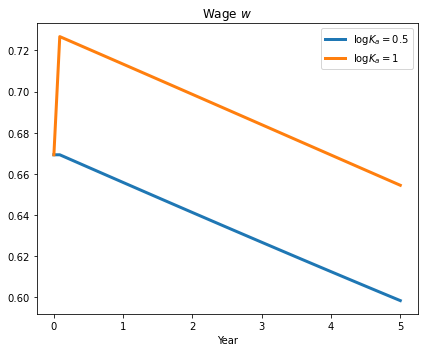

In [142]:
# Extract data
t1 = paths_case1["time_grid"]
Kg1 = paths_case1["w_path"]

t2 = paths_case2["time_grid"]
Kg2 = paths_case2["w_path"]

# Prepend the first element of Kg1 to both Kg1 and Kg2.
# Also, prepend the time zero to the time grid.
Kg1_new = np.insert(Kg1, 0, Kg1[0])
Kg2_new = np.insert(Kg2, 0, Kg1[0])
 

# Now plot the updated paths
plt.figure(figsize=(6, 5))
plt.plot(t1, Kg1_new, label="$\log{K_a}=0.5$", lw=3)
plt.plot(t2, Kg2_new, label="$\log{K_a}=1$", lw=3)
plt.title("Wage $w$")
plt.xlabel("Year")
plt.legend()
plt.tight_layout()
plt.show()

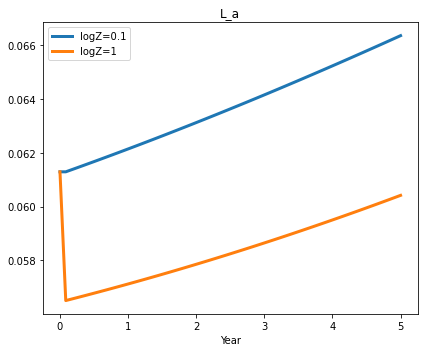

In [132]:
# Extract data
t1 = paths_case1["time_grid"]
Kg1 = paths_case1["L_a_path"]

t2 = paths_case2["time_grid"]
Kg2 = paths_case2["L_a_path"]

# Prepend the first element of Kg1 to both Kg1 and Kg2.
# Also, prepend the time zero to the time grid.
Kg1_new = np.insert(Kg1, 0, Kg1[0])
Kg2_new = np.insert(Kg2, 0, Kg1[0])
 

# Now plot the updated paths
plt.figure(figsize=(6, 5))
plt.plot(t1, Kg1_new, label="logZ=0.1", lw=3)
plt.plot(t2, Kg2_new, label="logZ=1", lw=3)
plt.title("L_a")
plt.xlabel("Year")
plt.legend()
plt.tight_layout()
plt.show()

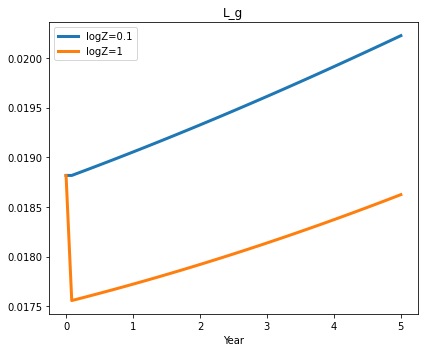

In [133]:
# Extract data
t1 = paths_case1["time_grid"]
Kg1 = paths_case1["L_g_path"]

t2 = paths_case2["time_grid"]
Kg2 = paths_case2["L_g_path"]

# Prepend the first element of Kg1 to both Kg1 and Kg2.
# Also, prepend the time zero to the time grid.
Kg1_new = np.insert(Kg1, 0, Kg1[0])
Kg2_new = np.insert(Kg2, 0, Kg1[0])
 

# Now plot the updated paths
plt.figure(figsize=(6, 5))
plt.plot(t1, Kg1_new, label="logZ=0.1", lw=3)
plt.plot(t2, Kg2_new, label="logZ=1", lw=3)
plt.title("L_g")
plt.xlabel("Year")
plt.legend()
plt.tight_layout()
plt.show()

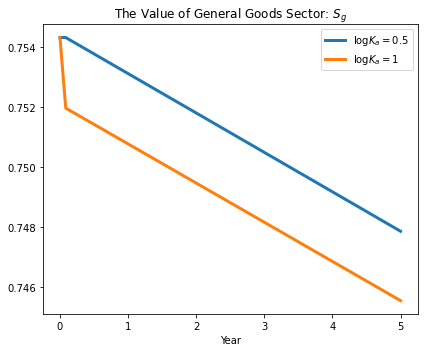

In [144]:
# Extract data
t1 = paths_case1["time_grid"]
Kg1 = paths_case1["s_g_path"]

t2 = paths_case2["time_grid"]
Kg2 = paths_case2["s_g_path"]

# Prepend the first element of Kg1 to both Kg1 and Kg2.
# Also, prepend the time zero to the time grid.
Kg1_new = np.insert(Kg1, 0, Kg1[0])
Kg2_new = np.insert(Kg2, 0, Kg1[0])
 

# Now plot the updated paths
plt.figure(figsize=(6, 5))
plt.plot(t1, Kg1_new, label="$\log{K_a}=0.5$", lw=3)
plt.plot(t2, Kg2_new, label="$\log{K_a}=1$", lw=3)
plt.title("The Value of General Goods Sector: $S_g$")
plt.xlabel("Year")
plt.legend()
plt.tight_layout()
plt.show()


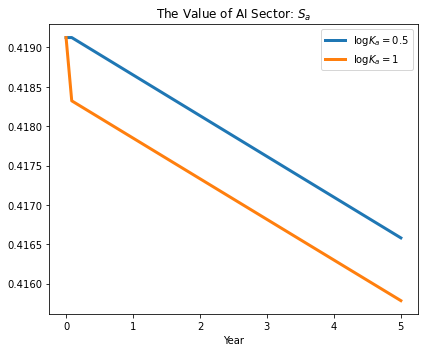

In [145]:
# Extract data
t1 = paths_case1["time_grid"]
Kg1 = paths_case1["s_a_path"]

t2 = paths_case2["time_grid"]
Kg2 = paths_case2["s_a_path"]

# Prepend the first element of Kg1 to both Kg1 and Kg2.
# Also, prepend the time zero to the time grid.
Kg1_new = np.insert(Kg1, 0, Kg1[0])
Kg2_new = np.insert(Kg2, 0, Kg1[0])
 

# Now plot the updated paths
plt.figure(figsize=(6, 5))
plt.plot(t1, Kg1_new, label="$\log{K_a}=0.5$", lw=3)
plt.plot(t2, Kg2_new, label="$\log{K_a}=1$", lw=3)
plt.title("The Value of AI Sector: $S_a$")
plt.xlabel("Year")
plt.legend()
plt.tight_layout()
plt.show()


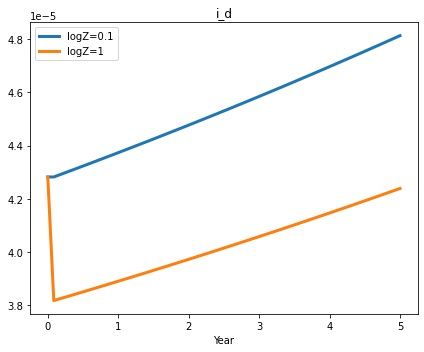

In [136]:
import numpy as np
import matplotlib.pyplot as plt

# Extract data
t1 = paths_case1["time_grid"]
Kg1 = paths_case1["i_d_path"]

t2 = paths_case2["time_grid"]
Kg2 = paths_case2["i_d_path"]

# Prepend the first element of Kg1 to both Kg1 and Kg2.
# Also, prepend the time zero to the time grid.
Kg1_new = np.insert(Kg1, 0, Kg1[0])
Kg2_new = np.insert(Kg2, 0, Kg1[0])
 

# Now plot the updated paths
plt.figure(figsize=(6, 5))
plt.plot(t1, Kg1_new, label="logZ=0.1", lw=3)
plt.plot(t2, Kg2_new, label="logZ=1", lw=3)
plt.title("i_d")
plt.xlabel("Year")
plt.legend()
plt.tight_layout()
plt.show()


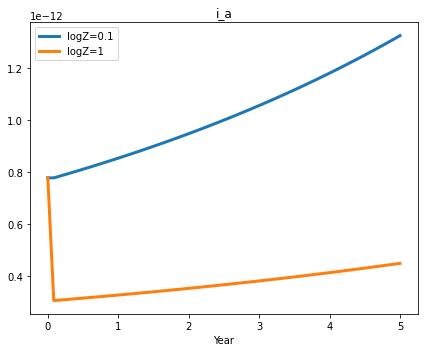

In [137]:
# Extract data
t1 = paths_case1["time_grid"]
Kg1 = paths_case1["i_a_path"]

t2 = paths_case2["time_grid"]
Kg2 = paths_case2["i_a_path"]

# Prepend the first element of Kg1 to both Kg1 and Kg2.
# Also, prepend the time zero to the time grid.
Kg1_new = np.insert(Kg1, 0, Kg1[0])
Kg2_new = np.insert(Kg2, 0, Kg1[0])
 

# Now plot the updated paths
plt.figure(figsize=(6, 5))
plt.plot(t1, Kg1_new, label="logZ=0.1", lw=3)
plt.plot(t2, Kg2_new, label="logZ=1", lw=3)
plt.title("i_a")
plt.xlabel("Year")
plt.legend()
plt.tight_layout()
plt.show()


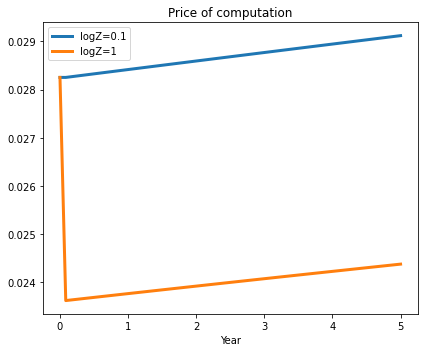

In [138]:
# Extract data
t1 = paths_case1["time_grid"]
Kg1 = paths_case1["p_path"]

t2 = paths_case2["time_grid"]
Kg2 = paths_case2["p_path"]

# Prepend the first element of Kg1 to both Kg1 and Kg2.
# Also, prepend the time zero to the time grid.
Kg1_new = np.insert(Kg1, 0, Kg1[0])
Kg2_new = np.insert(Kg2, 0, Kg1[0])
 

# Now plot the updated paths
plt.figure(figsize=(6, 5))
plt.plot(t1, Kg1_new, label="logZ=0.1", lw=3)
plt.plot(t2, Kg2_new, label="logZ=1", lw=3)
plt.title("Price of computation")
plt.xlabel("Year")
plt.legend()
plt.tight_layout()
plt.show()

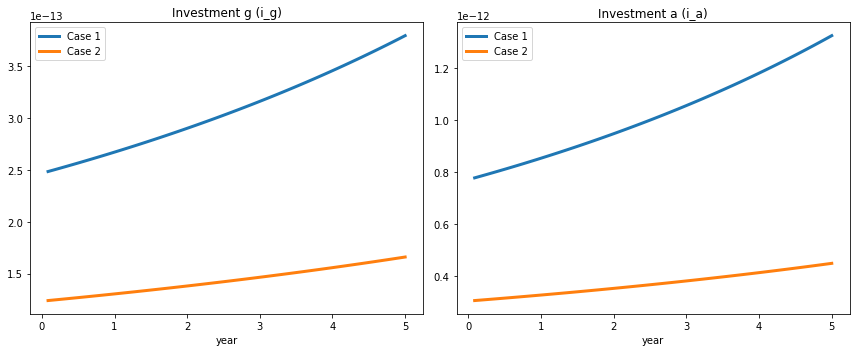

In [139]:
# Extract data
ti1 = paths_case1["time_grid"][1:]  # if you only want i_g after first step
ig1 = paths_case1["i_g_path"]
ia1 = paths_case1["i_a_path"]

ti2 = paths_case2["time_grid"][1:]
ig2 = paths_case2["i_g_path"]
ia2 = paths_case2["i_a_path"]

# Another figure for investments
plt.figure(figsize=(12, 5))

plt.subplot(1,2,1)
plt.plot(ti1, ig1, label="Case 1", lw=3)
plt.plot(ti2, ig2, label="Case 2", lw=3)
plt.title("Investment g (i_g)")
plt.xlabel("year")
plt.legend()

plt.subplot(1,2,2)
plt.plot(ti1, ia1, label="Case 1", lw=3)
plt.plot(ti2, ia2, label="Case 2", lw=3)
plt.title("Investment a (i_a)")
plt.xlabel("year")
plt.legend()

plt.tight_layout()
plt.show()


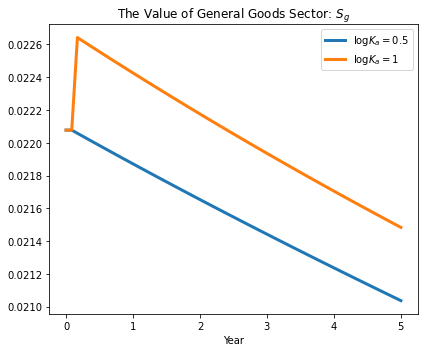

In [153]:
# Extract data
t1 = paths_case1["time_grid"]
Kg1 = paths_case1["Pi_g_path"]

t2 = paths_case2["time_grid"]
Kg2 = paths_case2["Pi_g_path"]

# Prepend the first element of Kg1 to both Kg1 and Kg2.
# Also, prepend the time zero to the time grid.
Kg1_new = np.insert(Kg1, 0, Kg1[0])
Kg2_new = np.insert(Kg2, 0, Kg1[0])
 

# Now plot the updated paths
plt.figure(figsize=(6, 5))
plt.plot(t1, Kg1_new, label="$\log{K_a}=0.5$", lw=3)
plt.plot(t2, Kg2_new, label="$\log{K_a}=1$", lw=3)
plt.title("The Value of General Goods Sector: $S_g$")
plt.xlabel("Year")
plt.legend()
plt.tight_layout()
plt.show()


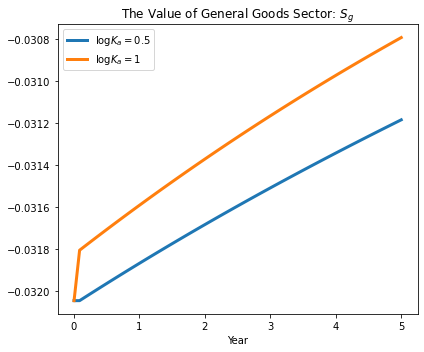

In [152]:
# Extract data
t1 = paths_case1["time_grid"]
Kg1 = paths_case1["Pi_a_path"]

t2 = paths_case2["time_grid"]
Kg2 = paths_case2["Pi_a_path"]

# Prepend the first element of Kg1 to both Kg1 and Kg2.
# Also, prepend the time zero to the time grid.
Kg1_new = np.insert(Kg1, 0, Kg1[0])
Kg2_new = np.insert(Kg2, 0, Kg1[0])


# Now plot the updated paths
plt.figure(figsize=(6, 5))
plt.plot(t1, Kg1_new, label="$\log{K_a}=0.5$", lw=3)
plt.plot(t2, Kg2_new, label="$\log{K_a}=1$", lw=3)
plt.title("The Value of General Goods Sector: $S_g$")
plt.xlabel("Year")
plt.legend()
plt.tight_layout()
plt.show()
